link up imgs in images/ with according id in data/legend.csv

In [1]:
import numpy as np
import data_processor
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from collections import defaultdict

%matplotlib inline

seed = 1234

# STEP 0 - GETTING THE DATA

In [2]:
get_data_from_file = False  # faster when this is False
DATA_IMG_SIZE = (100, 100)

# get data from file
if (get_data_from_file):
    DATA_FILE = "data_images_100_100.txt"
    data = np.genfromtxt(DATA_FILE)
    X = data[:, :-1]
    y = data[:, -1]

# generate data here
if not get_data_from_file:
    X, y = data_processor.convert_images(DATA_IMG_SIZE, True)
    X = np.array(X)
    y = np.char.lower(np.array(y))


--- Done reading legend.csv ---
--- Done turning images into vectors ---


In [3]:
print(X.shape)
print(y.shape)

(12765, 10000)
(12765,)


In [4]:
X_tr_unscaled, X_te_unscaled, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

scaler = StandardScaler()
scaler.fit(X_tr_unscaled)
X_tr = scaler.transform(X_tr_unscaled)     # We can forget about the original values & work
X_te = scaler.transform(X_te_unscaled)     #  just with the transformed values from here

In [5]:
X_tr_subset = X_tr[:10000]
y_tr_subset = y_tr[:10000]

In [7]:
print(X_tr.shape)

(11488, 10000)


In [8]:
neural_network = MLPClassifier(hidden_layer_sizes=[128],
                               activation='logistic',
                               solver='adam',
                               batch_size=200,
                               max_iter=500,
                               learning_rate='adaptive',
                               learning_rate_init=0.01,
                               random_state=seed)
neural_network.fit(X_tr_subset, y_tr_subset)

MLPClassifier(activation='logistic', batch_size=200, hidden_layer_sizes=[128],
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
              random_state=1234)

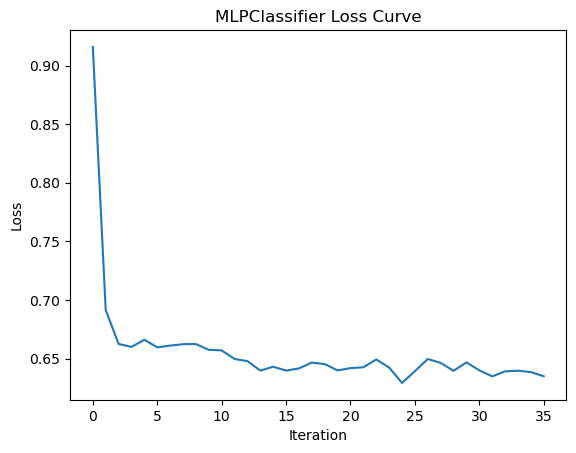

In [9]:
curve = neural_network.loss_curve_
plt.plot(curve)
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [10]:
yp = neural_network.predict(X_tr_subset)
countsp = defaultdict(int)
for i in yp:
    countsp[i] += 1
print(countsp)
print('training error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr_subset, neural_network.predict(X_tr_subset))])/len(y_tr_subset)))
print('validation error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr[10000:], neural_network.predict(X_tr[10000:,]))])/len(y_tr[10000:])))
print('test error rate: '+ str(sum([0 if y == yp else 1 for y, yp in zip(y_te, neural_network.predict(X_te))])/len(y_te)))

# the network has trouble predicting emotions like sadness, contempt, anger, disgust because there are few of them in the dataset compared to happiness and neutral.


defaultdict(<class 'int'>, {'neutral': 5147, 'happiness': 4703, 'surprise': 128, 'anger': 19, 'sadness': 1, 'contempt': 2})
training error rate: 0.2238
validation error rate: 0.271505376344086
test error rate: 0.23805794831636648


# Oversampling for Dataset Balance

In [11]:
counts = defaultdict(int)
for i in y:
    counts[i] += 1
print('before oversampling:')
print(counts)

# compute indices of classes
contempt_i = np.where(y == 'contempt')[0]
fear_i = np.where(y == 'fear')[0]
disgust_i = np.where(y == 'disgust')[0]
anger_i = np.where(y == 'anger')[0]
sadness_i = np.where(y == 'sadness')[0]
surprise_i = np.where(y == 'surprise')[0]

# calculate how many times to duplicate data
contempt_times = int(counts['neutral'] / counts['contempt']) - 1
fear_times = int(counts['neutral'] / counts['fear']) - 1
disgust_times = int(counts['neutral'] / counts['disgust']) - 1
anger_times = int(counts['neutral'] / counts['anger']) - 1
sadness_times = int(counts['neutral'] / counts['sadness']) - 1
surprise_times = int(counts['neutral'] / counts['surprise']) - 1

contempt_X = np.repeat(X[contempt_i], contempt_times, axis=0)
fear_X = np.repeat(X[fear_i], fear_times, axis=0)
disgust_X = np.repeat(X[disgust_i], disgust_times, axis=0)
anger_X = np.repeat(X[anger_i], anger_times, axis=0)
sadness_X = np.repeat(X[sadness_i], sadness_times, axis=0)
surprise_X = np.repeat(X[surprise_i], surprise_times, axis=0)

X_balanced = np.concatenate((X, contempt_X, fear_X, disgust_X, anger_X, sadness_X, surprise_X), axis=0)
y_balanced = np.concatenate((y,
                                np.repeat(['contempt'], contempt_times * counts['contempt']),
                                np.repeat(['fear'], fear_times * counts['fear']),
                                np.repeat(['disgust'], disgust_times * counts['disgust']),
                                np.repeat(['anger'], anger_times * counts['anger']),
                                np.repeat(['sadness'], sadness_times * counts['sadness']),
                                np.repeat(['surprise'], surprise_times * counts['surprise'])), axis=0)

counts_after = defaultdict(int)
for i in y_balanced:
    counts_after[i] += 1
print('\nafter:')
print(counts_after)







before oversampling:
defaultdict(<class 'int'>, {'neutral': 6717, 'happiness': 5309, 'surprise': 355, 'sadness': 124, 'anger': 227, 'contempt': 9, 'disgust': 12, 'fear': 12})

after:
defaultdict(<class 'int'>, {'neutral': 6717, 'happiness': 5309, 'surprise': 6390, 'sadness': 6696, 'anger': 6583, 'contempt': 6714, 'disgust': 6708, 'fear': 6708})


In [12]:
# shuffle oversampled data
np.random.seed(seed)
shuffled_indices = np.arange(y_balanced.shape[0])
np.random.shuffle(shuffled_indices)

X_tr_balanced_shuffled = X_balanced[shuffled_indices]
y_tr_balanced_shuffled = y_balanced[shuffled_indices]

In [16]:
X_tr_unscaled, X_te_unscaled, y_tr, y_te = train_test_split(X_tr_balanced_shuffled, y_tr_balanced_shuffled, test_size=0.1, random_state=seed, shuffle=True)

scaler = StandardScaler()
scaler.fit(X_tr_unscaled)
X_tr = scaler.transform(X_tr_unscaled)     # We can forget about the original values & work
X_te = scaler.transform(X_te_unscaled)     #  just with the transformed values from here

In [18]:
X_tr_subset = X_tr[:40000]
y_tr_subset = y_tr[:40000]
print(X_tr.shape)


(46642, 10000)


In [22]:
neural_network = MLPClassifier(hidden_layer_sizes=[64, 64],
                               activation='logistic',
                               solver='adam',
                               batch_size=200,
                               max_iter=500,
                               learning_rate='adaptive',
                               learning_rate_init=0.01,
                               random_state=seed)
neural_network.fit(X_tr_subset, y_tr_subset)


MLPClassifier(activation='logistic', batch_size=200,
              hidden_layer_sizes=[64, 64], learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=500, random_state=1234)

In [45]:
import joblib

joblib.dump(neural_network, '64x64.pkl')

['64x64.pkl']

In [46]:
nn = joblib.load('saved_networks/64x64.pkl')


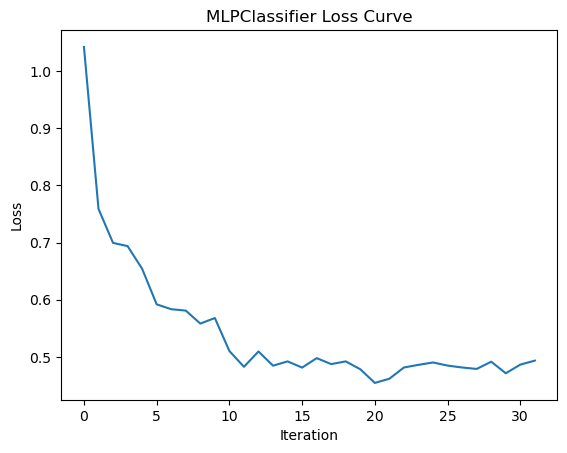

In [23]:
curve = neural_network.loss_curve_
plt.plot(curve)
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [24]:
yp = neural_network.predict(X_tr)
countsp = defaultdict(int)
for i in yp:
    countsp[i] += 1
print('with layers = [64, 64]')
print('training error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr_subset, neural_network.predict(X_tr_subset))])/len(y_tr_subset)))
print('validation error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr[40000:], neural_network.predict(X_tr[40000:,]))])/len(y_tr[10000:])))
print('evaluation error rate: '+ str(sum([0 if y == yp else 1 for y, yp in zip(y_te, neural_network.predict(X_te))])/len(y_te)))


# wrong_i = np.where((yp != y_tr))[0]
# print(wrong_i.shape)
# r = 10
# c = 5

# fig, ax = plt.subplots(r,c)
# fig.set_figheight(30)
# fig.set_figwidth(15)
# for i in range(r):
#     for j in range(c):
#         ax[i, j].imshow(X_tr_unscaled[wrong_i[i*r + j]].reshape(100,100), cmap='gray')
#         ax[i, j].set_title(y_tr_subset[wrong_i[i*r + j]] + '-' + yp[wrong_i[i*r + j]])

with layers = [64, 64]
training error rate: 0.157775
validation error rate: 0.029365209322635227
evaluation error rate: 0.17210109974918


In [19]:
# trying with 1 hidden layer of 128 nodes

neural_network_2 = MLPClassifier(hidden_layer_sizes=[128],
                               activation='logistic',
                               solver='adam',
                               batch_size=200,
                               max_iter=500,
                               learning_rate='adaptive',
                               learning_rate_init=0.01,
                               random_state=seed)
neural_network_2.fit(X_tr_subset, y_tr_subset)

MLPClassifier(activation='logistic', batch_size=200, hidden_layer_sizes=[128],
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
              random_state=1234)

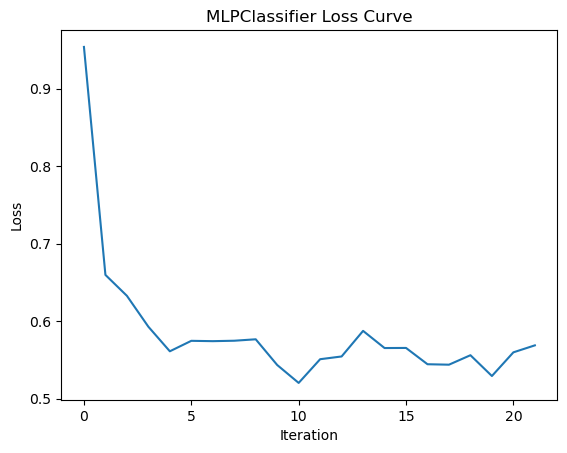

In [20]:
curve = neural_network_2.loss_curve_
plt.plot(curve)
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [21]:
yp = neural_network_2.predict(X_tr_subset)
countsp = defaultdict(int)
for i in yp:
    countsp[i] += 1
print('with layers = [128]')
print('training error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr_subset, neural_network_2.predict(X_tr_subset))])/len(y_tr_subset)))
print('validation error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr[40000:], neural_network.predict(X_tr[40000:,]))])/len(y_tr[10000:])))
print('evaluation error rate: '+ str(sum([0 if y == yp else 1 for y, yp in zip(y_te, neural_network_2.predict(X_te))])/len(y_te)))
# wrong_i = np.where((yp != y_tr_subset))[0]
# print(wrong_i.shape)

# r = 10
# c = 5

# fig, ax = plt.subplots(r,c)
# fig.set_figheight(30)
# fig.set_figwidth(15)
# for i in range(r):
#     for j in range(c):
#         ax[i, j].imshow(X_tr_unscaled[wrong_i[i*r + j]].reshape(100,100), cmap='gray')
#         ax[i, j].set_title(y_tr_subset[wrong_i[i*r + j]] + '-' + yp[wrong_i[i*r + j]])

with layers = [128]
training error rate: 0.167275
validation error rate: 0.03607881665847934
evaluation error rate: 0.18039745321242523


In [55]:
# save network
joblib.dump(neural_network_2, 'saved_networks/128.pkl')

['saved_networks/128.pkl']